In [65]:
import pandas as pd
import numpy as np
import psycopg2
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from matplotlib.cbook import boxplot_stats
import datetime


In [66]:
conn = psycopg2.connect(host="localhost", database="gastos", user="postgres", password="postgres")

In [67]:
query = '''
select *
from dtm.gastos_fact g
inner join dtm.dia d on d.dia_key = g.dia_key
inner join dtm.subcategoria s on s.subcategoria_key = g.subcategoria_key
'''

In [68]:
df = pd.read_sql_query(query,con=conn)

In [69]:
df = df.set_index("fecha")

# Fechas de analisis

In [70]:
inicio_filtro = datetime.date(2020, 1, 1)
fin_filtro = datetime.date(2022, 3, 1)

filtro = df[(df.index>=inicio_filtro) & (df.index<=fin_filtro) ]

# Suma de gastos por mes y año (con tendencia)

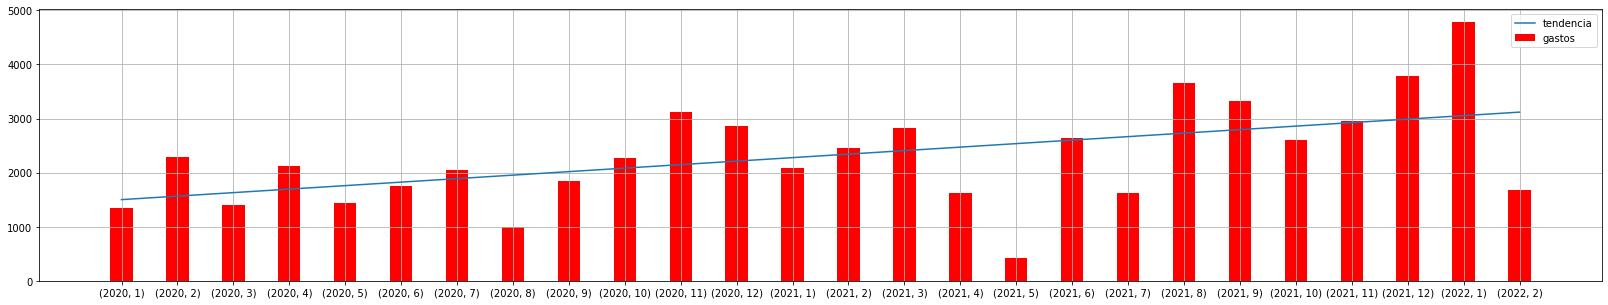

In [71]:
gastos_ac = filtro.groupby(["anio","mes"])["importe"].agg("sum").abs()

#Linear regresion fot trend calculation
X = np.arange(len(gastos_ac.index)).reshape(-1, 1)
y = gastos_ac.to_numpy()

lr = LinearRegression()
lr.fit(X, y)
y_pred = lr.predict(X)

#PLOT
plt.figure(figsize=(28,5))
#plt.bar(x=range(len(ingresos_ac.index)), height=ingresos_ac, label="ingresos", color="g", tick_label=ingresos_ac.index,align="edge", width=-0.4)
plt.bar(x=range(len(gastos_ac.index)), height=gastos_ac.abs(), label="gastos", color="r", tick_label=gastos_ac.index, align="center", width=0.4)
plt.plot(X, y_pred, label = "tendencia")
plt.legend()
plt.grid()


# **Comparativa por años de suma de gastos por mes y año**

<AxesSubplot:xlabel='mes'>

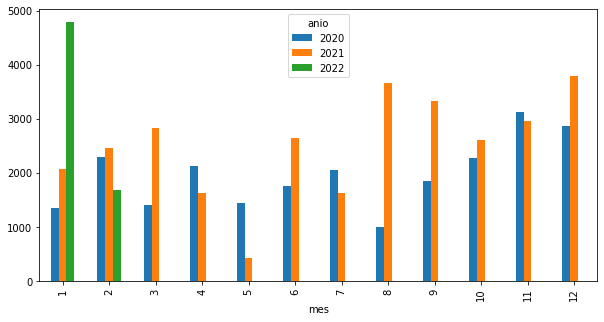

In [74]:
comparativa = filtro.groupby(["mes","anio"])["importe"].agg("sum").abs()
comparativa = comparativa.unstack()
comparativa.plot.bar(figsize=(10,5))

**Media mensual de gastos por año**

anio
2020    1963.795833
2021    2502.368333
2022    3234.245000
Name: importe, dtype: float64


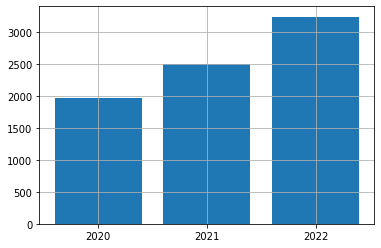

In [61]:
gastos_ac = filtro.groupby(["anio","mes"])["importe"].agg("sum").abs()
gastos_ac2 = gastos_ac.groupby(["anio"]).agg("mean")
plt.bar(gastos_ac2.index,gastos_ac2, tick_label=gastos_ac2.index)
plt.grid()
print(gastos_ac2)

**Desglose por mes y categoria**

categoria                                                                                                                                                                                                 anio
Alimentación                                                                                                                                                                                              2020    5524.37
                                                                                                                                                                                                          2021    6579.99
                                                                                                                                                                                                          2022     763.58
Compras                                                                                                                                    

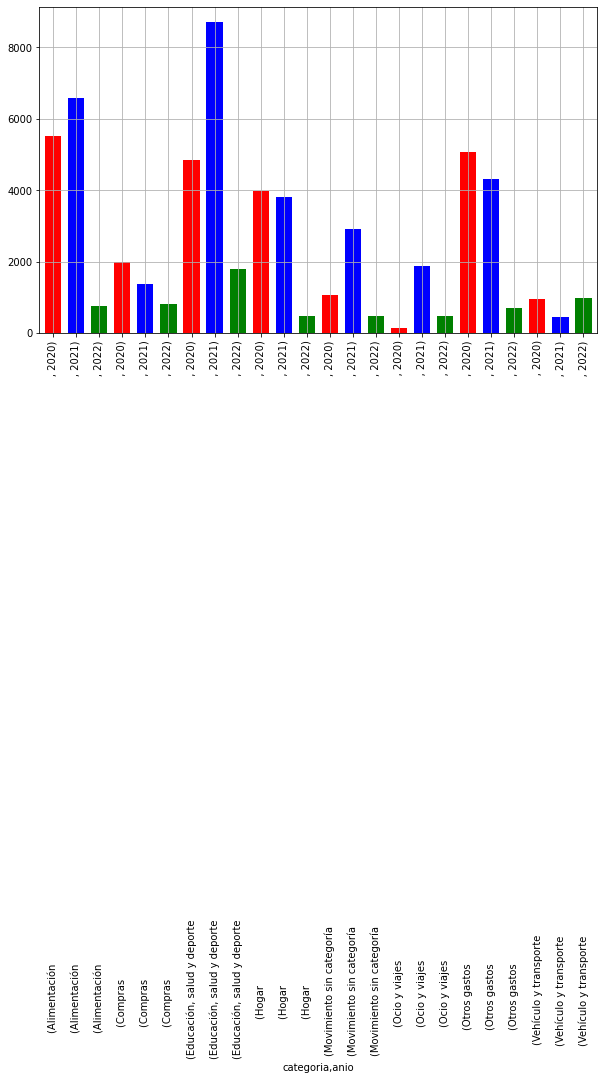

In [87]:
test = filtro[filtro.importe<0].groupby(["anio","categoria"])["importe"].agg("sum").abs()
test2 = test.unstack(fill_value=0)
t = test2.unstack()
t.plot.bar(figsize=(10,6), width=0.7, color=["r","b","g"], grid=True)
t

# Vamos a intentar quitar atípicos

<AxesSubplot:>

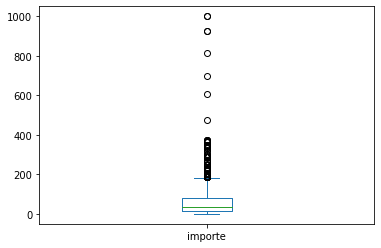

In [83]:
filtro["importe"].abs().plot.box()

vamos a ver los gastos de agosto

In [64]:
filtro[(filtro.mes == 3) & (filtro.anio == 2021)].sort_values(by="importe", ascending=True).head(10)

,gastos_fact_key,importe,dia_key,subcategoria_key,saldo,dia,mes,anio,dia_key,subcategoria_key,subcategoria,categoria
fecha,,,,,,,,,,,,
2021-03-02,1433,-700.00,844,123,698.39,2,3,2021,844,123,Transacción entre cuentas de ahorro ...,Movimiento sin categoría ...
2021-03-01,1429,-287.50,843,100,-333.17,1,3,2021,843,100,Educación ...,"Educación, salud y deporte ..."
2021-03-01,1430,-287.50,843,100,-227.03,1,3,2021,843,100,Educación ...,"Educación, salud y deporte ..."
2021-03-02,1434,-250.00,844,123,448.39,2,3,2021,844,123,Transacción entre cuentas de ahorro ...,Movimiento sin categoría ...
2021-03-31,1455,-180.00,861,124,1317.99,31,3,2021,861,124,Transferencias ...,Otros gastos ...
2021-03-02,1435,-145.58,844,96,1398.39,2,3,2021,844,96,Comunidad ...,Hogar ...
2021-03-31,1456,-128.75,861,119,1189.24,31,3,2021,861,119,Ropa y complementos ...,Compras ...
2021-03-06,1438,-121.76,847,121,241.63,6,3,2021,847,121,Supermercados y alimentación ...,Alimentación ...
2021-03-11,1441,-100.00,849,124,87.15,11,3,2021,849,124,Transferencias ...,Otros gastos ...
